<h1 align="center">MetPy: An Open Source Python Toolkit for Meteorology<h1>
<h3 align="center">Ryan May<br>UCAR/Unidata<br>22 June 2015<br></h3>

## Who am I?

- Software Engineer at Unidata
- Been here for a year and a half
- Work on THREDDS
- Pythonista
- I like long walks on the beach and watching Longhorns lose football games
- Twitter/GitHub: @dopplershift

#What is MetPy?

- Python toolkit for Meteorology
    - Reading in weather data formats
    - Re-usable calculation routines
    - Weather plots
- Intended for use by anyone in the field: Education, Research, etc.
- Goal is to become a community resource to find useful bits and pieces

Design philosophy:
- Fit well with the rest of the scientific Python ecosystem (NumPy, Matplotlib, etc.)
- Simple to use with your own data
- Unit correctness built-in (using `pint`)
- Well-tested and documented
- Development driven by use cases

#What can MetPy do?

## Reading Data
Pure python implementations for NEXRAD files:
- Level 2
- Level 3

## Example of using NIDS decoding

In [1]:
# Level 3 example with multiple products
import numpy as np
import matplotlib.pyplot as plt
from numpy import ma

from metpy.cbook import get_test_data
from metpy.io.nexrad import Level3File
from metpy.plots import ctables

In [2]:
# Helper code for making sense of these products. This is hidden from the slideshow
# and eventually, in some form, will make its way into MetPy proper.
def print_tab_pages(prod):
    print(('\n' + '-'*80 + '\n').join(prod.tab_pages))

def print_graph_pages(prod):
    colors = {0:'white', 3:'red', 4:'cyan'}
    for page in prod.graph_pages:
        fig, ax = plt.subplots(1, 1, figsize=(10,10))
        ax.axesPatch.set_facecolor('black')
        for line in page:
            if 'color' in line:
                c = colors[line['color']]
                if 'text' in line:
                    ax.text(line['x'], line['y'], line['text'], color=c,
                            transform=ax.transData, verticalalignment='top',
                            horizontalalignment='left', fontdict={'family':'monospace'},
                            fontsize=8)
                else:
                    vecs = np.array(line['vectors'])
                    ax.plot(vecs[:, ::2], vecs[:, 1::2], color=c)
        ax.set_xlim(0, 639)
        ax.set_ylim(511, 0)
        ax.set_aspect('equal', 'box')
        ax.xaxis.set_major_formatter(plt.NullFormatter())
        ax.xaxis.set_major_locator(plt.NullLocator())
        ax.yaxis.set_major_formatter(plt.NullFormatter())
        ax.yaxis.set_major_locator(plt.NullLocator())
        for s in ax.spines: ax.spines[s].set_color('none')

def plot_prod(prod, cmap, norm, ax=None):
    if ax is None:
        ax = plt.gca()

    data_block = prod.sym_block[0][0]
    data = np.array(data_block['data'])
    data = prod.map_data(data)
    data = np.ma.array(data, mask=np.isnan(data))
    if 'start_az' in data_block:
        az = np.array(data_block['start_az'] + [data_block['end_az'][-1]])
        rng = np.linspace(0, prod.max_range, data.shape[-1] + 1)
        x = rng * np.sin(np.deg2rad(az[:, None]))
        y = rng * np.cos(np.deg2rad(az[:, None]))
    else:
        x = np.linspace(-prod.max_range, prod.max_range, data.shape[1] + 1)
        y = np.linspace(-prod.max_range, prod.max_range, data.shape[0] + 1)
        data = data[::-1]
    pc = ax.pcolormesh(x, y, data, cmap=cmap, norm=norm)
    plt.colorbar(pc, extend='both')
    ax.set_aspect('equal', 'datalim')
    ax.set_xlim(-100, 100)
    ax.set_ylim(-100, 100)
    return pc, data

def plot_points(prod, ax=None):
    if ax is None:
        ax = plt.gca()

    data_block = prod.sym_block[0]
    styles = {'MDA': dict(marker='o', markerfacecolor='None', markeredgewidth=2, size='radius'),
              'MDA (Elev.)': dict(marker='s', markerfacecolor='None', markeredgewidth=2, size='radius'),
              'TVS': dict(marker='v', markerfacecolor='red', markersize=10),
              'Storm ID': dict(text='id'),
              'HDA': dict(marker='o', markersize=10, markerfacecolor='blue', alpha=0.5)}
    artists = []
    for point in data_block:
        if 'type' in point:
            info = styles.get(point['type'], {}).copy()
            x,y = point['x'], point['y']
            text_key = info.pop('text', None)
            if text_key:
                artists.append(ax.text(x, y, point[text_key], transform=ax.transData, clip_box=ax.bbox, **info))
                artists[-1].set_clip_on(True)
            else:
                size_key = info.pop('size', None)
                if size_key:
                    info['markersize'] = np.pi * point[size_key]**2
                artists.append(ax.plot(x, y, **info))

def plot_tracks(prod, ax=None):
    if ax is None:
        ax = plt.gca()
        
    data_block = prod.sym_block[0]

    for track in data_block:
        if 'marker' in track:
            pass
        if 'track' in track:
            x,y = np.array(track['track']).T
            ax.plot(x, y, color='k')

In [3]:
# Read in a bunch of NIDS products
tvs = Level3File(get_test_data('nids/KOUN_SDUS64_NTVTLX_201305202016'))
nmd = Level3File(get_test_data('nids/KOUN_SDUS34_NMDTLX_201305202016'))
nhi = Level3File(get_test_data('nids/KOUN_SDUS64_NHITLX_201305202016'))
n0q = Level3File(get_test_data('nids/KOUN_SDUS54_N0QTLX_201305202016'))
nst = Level3File(get_test_data('nids/KOUN_SDUS34_NSTTLX_201305202016'))

In [4]:
# What happens when we print one out
tvs

No Filename: Tornado Vortex Signature
MsgHdr(code=61, date=15846, time=73258, msg_len=3228, src_id=1, dest_id=0, num_blks=5)
ProdDesc(divider=-1, lat=35333, lon=-97278, height=1277, prod_code=61, op_mode=2, vcp=12, seq_num=1430, vol_num=28, vol_date=15846, vol_start_time=73003, prod_gen_date=15846, prod_gen_time=73258, dep1=0, dep2=0, el_num=0, dep3=0, thr1=0, thr2=0, thr3=0, thr4=0, thr5=0, thr6=0, thr7=0, thr8=0, thr9=0, thr10=0, thr11=0, thr12=0, thr13=0, thr14=0, thr15=0, thr16=0, dep4=4, dep5=0, dep6=0, dep7=0, dep8=0, dep9=0, dep10=0, version=1, spot_blank=0, sym_off=60, graph_off=104, tab_off=398)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 4, 0, 0, 0, 0, 0, 0]
{'vol_time': datetime.datetime(2013, 5, 20, 14, 16, 43), 'num_tvs': 4, 'msg_time': datetime.datetime(2013, 5, 20, 14, 20, 58), 'num_etvs': 0, 'prod_time': datetime.datetime(2013, 5, 20, 14, 20, 58)}
TLX

In [5]:
# Can print tabular (ASCII) information in the product
print_tab_pages(tvs)

                                                                                
                            Tornado Vortex Signature                            
      Radar Id   1   Date/Time  05:20:13/20:16:43   Number of TVS/ETVS    4/  0 
                                                                                
 Feat  Storm   AZ/RAN  AVGDV  LLDV  MXDV/Hgt   Depth    Base/Top   MXSHR/Hgt    
 Type    ID   (deg,nm)  (kt)  (kt)  (kt,kft)   (kft)     (kft)     (E-3/s,kft)  
                                                                                
  TVS    M0   268/ 12    79   126   126/ 0.8   >19.1  < 0.8/>19.8   179/ 6.2    
  TVS    D0   216/ 52    34    41    84/15.1   >24.7  < 4.9/ 29.6    26/15.1    
  TVS    D0   211/ 52    29    30    72/12.0    20.9    7.0/ 28.0    22/12.0    
  TVS    D0   208/ 48    35    27    75/13.8   >22.9  < 4.3/ 27.2    25/13.8    
--------------------------------------------------------------------------------
                 TORNADO VOR

What about the "data" content of the products?

(-50, 20)

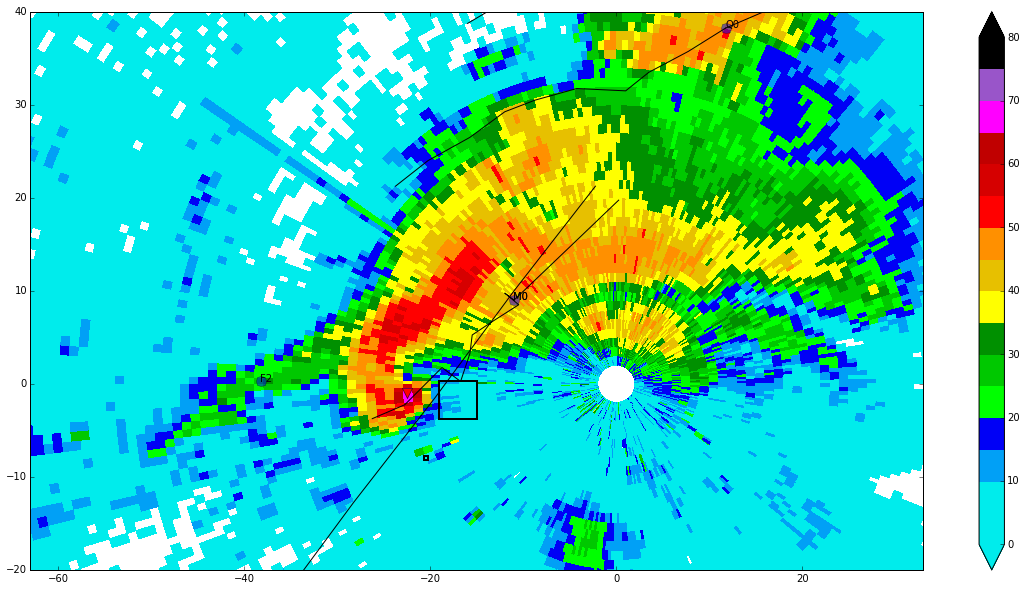

In [6]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)
norm, cmap = ctables.registry.get_with_boundaries('NWSReflectivity', np.arange(0, 85, 5))
pc, data = plot_prod(n0q, cmap, norm, ax)
plot_points(tvs)
plot_points(nmd)
plot_points(nhi)
plot_tracks(nst)
ax.set_ylim(-20, 40)
ax.set_xlim(-50, 20)

##Calculations
- Basic calculations (e.g. heat index, wind components)
- Kinematic calculations (e.g. vertical vorticity)
- Thermodynamic calculations (e.g. dewpoint, LCL)
- Turbulence (e.g. turbulence kinetic energy)

- Calculations simple and independent to promote re-use
- Only requirement is to use unit support

## Example
It's 86F outside here (pressure 860 mb), with a relative humidity of 40%. What's the dewpoint?

In [7]:
import metpy.calc as mcalc
from metpy.units import units
temp = 86 * units.degF
press = 860. * units.mbar
humidity = 40 / 100.

In [8]:
dewpt = mcalc.dewpoint_rh(temp, humidity).to('degF')
dewpt

<Quantity(58.904391157249485, 'degF')>

What does the LCL look like for that?

In [9]:
mcalc.lcl(press, temp, dewpt)

<Quantity(690.7279935805985, 'millibar')>

Given those conditions, what does the profile of a parcel look like?

In [10]:
import numpy as np
pressure_levels = np.array([860., 850., 700., 500., 300.]) * units.mbar
mcalc.parcel_profile(pressure_levels, temp, dewpt)

<Quantity([ 303.14999978  302.13813484  285.82594985  272.21678105  247.74142449], 'kelvin')>

## Plots
- Colortables
- Skew-T

## Example
Plot some sounding data

In [11]:
import matplotlib.pyplot as plt
import numpy as np

from metpy.cbook import get_test_data
from metpy.calc import get_wind_components
from metpy.plots import SkewT

# Parse the data
p, T, Td, direc, spd = np.loadtxt(get_test_data('sounding_data.txt'),
        usecols=(0, 2, 3, 6, 7), skiprows=4, unpack=True)
u, v = get_wind_components(spd, np.deg2rad(direc))

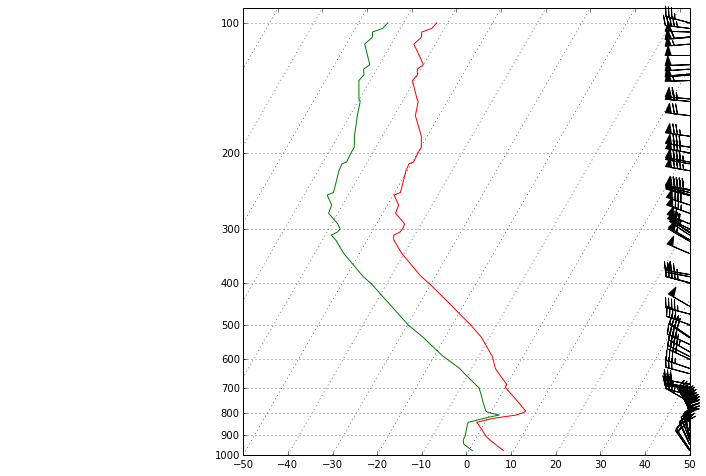

In [12]:
# Create a skewT using matplotlib's default figure size
fig = plt.figure(figsize=(8, 8))
skew = SkewT(fig)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.plot_barbs(p, u, v)

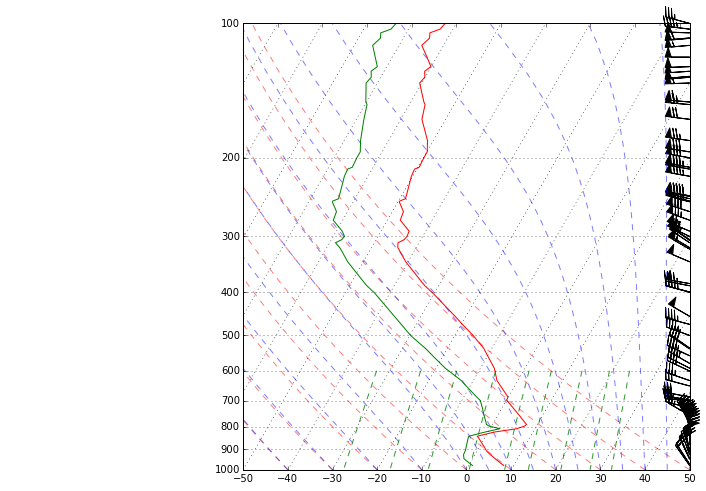

In [13]:
# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()
skew.ax.set_ylim(1000, 100)
fig

#Siphon: Sucking data down the pipe

# THREDDS?
- Unidata technology for serving many different data formats
- Creates "feature collections" on top of data files to provide access across multiple files
- Provides a variety of access services on top of these datasets
- Demonstration server: http://thredds.ucar.edu/thredds/catalog.html

Siphon is Unidata's Python library for talking to THREDDS:
- Making sense of catalogs
- Talking to the NetCDF Subset Service (NCSS)
- Talking to the radar query service (radar server)

## Example
Let's use Siphon to get the forecast from the GFS. Start by finding it on [THREDDS.](http://thredds.ucar.edu/thredds/catalog.html)

In [14]:
from siphon.catalog import TDSCatalog
best_gfs = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p5deg/catalog.xml?dataset=grib/NCEP/GFS/Global_0p5deg/Best')
best_ds = list(best_gfs.datasets.values())[0]

In [15]:
best_ds.access_urls

{'CdmRemote': 'http://thredds.ucar.edu/thredds/cdmremote/grib/NCEP/GFS/Global_0p5deg/Best',
 'ISO': 'http://thredds.ucar.edu/thredds/iso/grib/NCEP/GFS/Global_0p5deg/Best',
 'NCML': 'http://thredds.ucar.edu/thredds/ncml/grib/NCEP/GFS/Global_0p5deg/Best',
 'NetcdfSubset': 'http://thredds.ucar.edu/thredds/ncss/grib/NCEP/GFS/Global_0p5deg/Best',
 'OPENDAP': 'http://thredds.ucar.edu/thredds/dodsC/grib/NCEP/GFS/Global_0p5deg/Best',
 'UDDC': 'http://thredds.ucar.edu/thredds/uddc/grib/NCEP/GFS/Global_0p5deg/Best',
 'WCS': 'http://thredds.ucar.edu/thredds/wcs/grib/NCEP/GFS/Global_0p5deg/Best',
 'WMS': 'http://thredds.ucar.edu/thredds/wms/grib/NCEP/GFS/Global_0p5deg/Best'}

Ok, let's get data using NCSS

In [16]:
# Set up a class to access
from siphon.ncss import NCSS
ncss = NCSS(best_ds.access_urls['NetcdfSubset'])

# Get today's date
from datetime import datetime, timedelta
now = datetime.utcnow()

# Get a query object and set to get temperature for Boulder for the next 7 days
query = ncss.query()
query.lonlat_point(-105, 40).vertical_level(100000).time_range(now, now + timedelta(days=7))
query.variables('Temperature_isobaric').accept('netcdf4')

# Get the Data
data = ncss.get_data(query)
list(data.variables.keys())

['isobaric3',
 'Temperature_isobaric',
 'station_name',
 'station_description',
 'latitude',
 'longitude',
 'time']

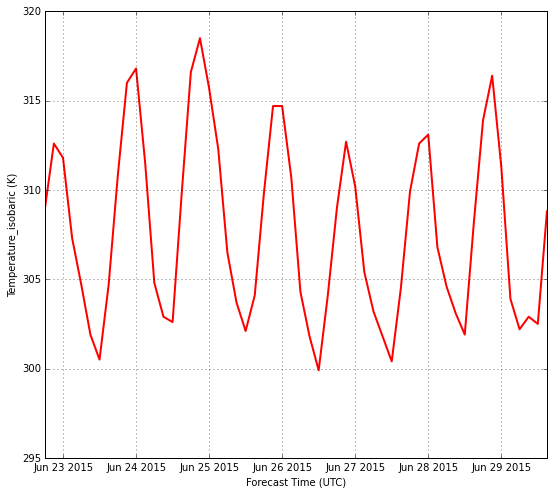

In [17]:
# Pull the variables we want from the NetCDF file
temp = data.variables['Temperature_isobaric']
time = data.variables['time']

# Convert time values from numbers to datetime
from netCDF4 import num2date
time_vals = num2date(time[:].squeeze(), time.units)

# Plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(9, 8))
ax.plot(time_vals, temp[:].squeeze(), 'r', linewidth=2)
ax.set_ylabel(temp.standard_name + ' (%s)' % temp.units)
ax.set_xlabel('Forecast Time (UTC)')
ax.grid(True)

# "With your powers combined..."

- Siphon is a complementary technology to Metpy
- Provides an easy way to get data for use in MetPy

## Example
Let's plot a forecast sounding from GFS for Boulder 12 hours from now

In [18]:
# Re-use the NCSS access from earlier, but make a new query
query = ncss.query()
query.lonlat_point(-105, 40).time(now + timedelta(hours=12)).accept('csv')
query.variables('Temperature_isobaric', 'Relative_humidity_isobaric',
                'u-component_of_wind_isobaric', 'v-component_of_wind_isobaric')
data = ncss.get_data(query)

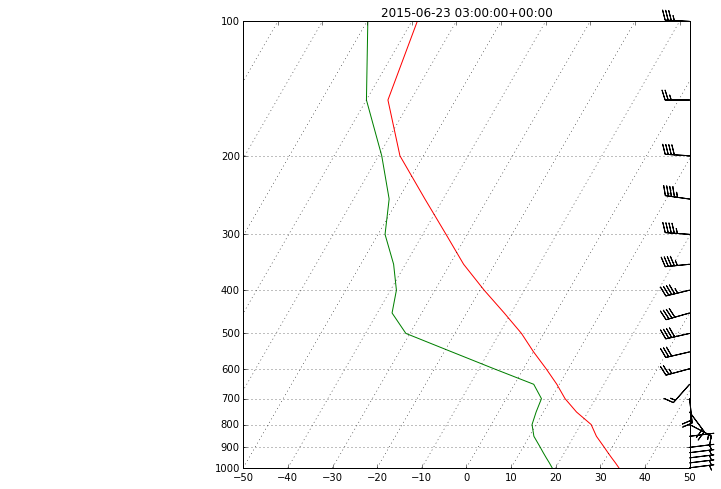

In [19]:
# Pull out data with some units
p = (data['vertCoord'] * units('Pa')).to('mbar')
T = data['Temperature_isobaric'] * units('kelvin')
Td = mcalc.dewpoint_rh(T, data['Relative_humidity_isobaric'] / 100.)
u = data['ucomponent_of_wind_isobaric'] * units('m/s')
v = data['vcomponent_of_wind_isobaric'] * units('m/s')

# Create a skewT using matplotlib's default figure size
fig = plt.figure(figsize=(8, 8))
skew = SkewT(fig)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T.to('degC'), 'r')
skew.plot(p, Td.to('degC'), 'g')

skew.plot_barbs(p[p>=100 * units.mbar], u.to('knots')[p>=100 * units.mbar],
                v.to('knots')[p>=100 * units.mbar])
skew.ax.set_ylim(1000, 100)
skew.ax.set_title(data['date'][0]);

# Ideas for the future

A sampling from our issue tracker:
- Station plots (with weather symbols)
- Hodograph
- Pulling in sounding data from Wyoming archive

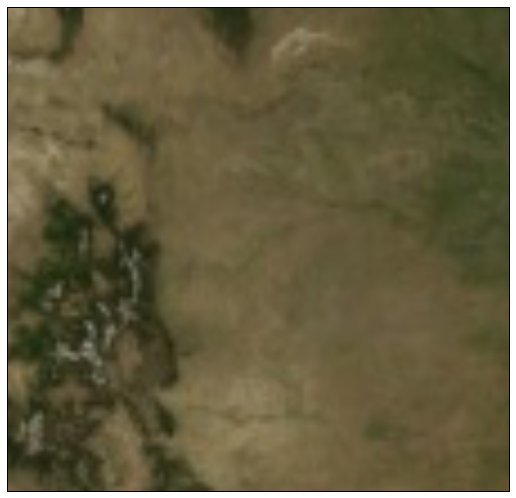

In [20]:
# This code isn't actually in a MetPy release yet.....
import importlib
import metpy.plots.station_plot
importlib.reload(metpy.plots.station_plot)
station_plot = metpy.plots.station_plot.station_plot

# Set up query for point data
ncss = NCSS('http://thredds.ucar.edu/thredds/ncss/nws/metar/ncdecoded/Metar_Station_Data_fc.cdmr/dataset.xml')
query = ncss.query()
query.lonlat_box(44, 37, -98, -108).time(now - timedelta(days=2)).accept('csv')
query.variables('air_temperature', 'dew_point_temperature',
                'wind_from_direction', 'wind_speed')
data = ncss.get_data(query)

# Some unit conversions
speed = data['wind_speed'] * units('m/s')
data['u'],data['v'] = mcalc.get_wind_components(speed.to('knots'),
                                                data['wind_from_direction'] * units('degree'))

# Plot using basemap for now
from mpl_toolkits.basemap import Basemap
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(1, 1, 1)
m = Basemap(lon_0=-105, lat_0=40, lat_ts=40, resolution='i',
            projection='stere', urcrnrlat=44, urcrnrlon=-98, llcrnrlat=37,
            llcrnrlon=-108, ax=ax)
m.bluemarble()

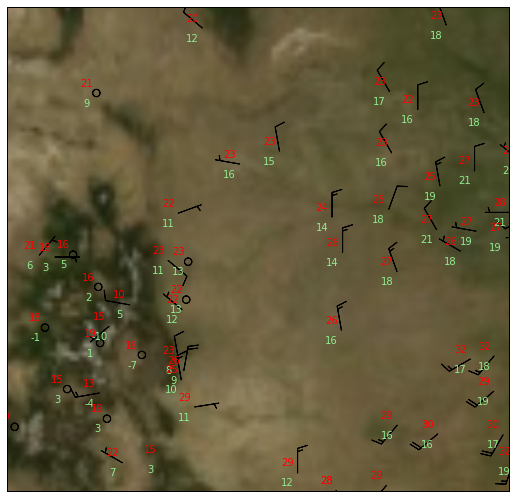

In [21]:
# Just an early prototype...
station_plot(data, proj=m, ax=ax, layout={'NW': 'air_temperature', 'SW': 'dew_point_temperature'},
             styles={'air_temperature': dict(color='r'), 'dew_point_temperature': dict(color='lightgreen')},
             zorder=1);
fig

- Need more use cases to drive development
- Writing examples reveals what parts are missing or require too much code

#Community Participation

## Infrastructure
- The project is built around automation to make it easy to maintain:
  - Automated tests (unit and style checking) on [Travis CI](http://www.travis-ci.org/metpy/MetPy)
  - Test coverage using [Coverall.io](https://coveralls.io/r/metpy/MetPy)
  - Automatic code quality checks on [Landscape.io](https://landscape.io/github/metpy/MetPy/master)
  - Automatic documentation generation from [Read the Docs](http://metpy.rtfd.org)

- This is the long way of saying: it's really easy to incorporate new things and keep things up to date and working

- For Siphon:
  - [Travis CI](http://www.travis-ci.org/Unidata/siphon)
  - [Coverall.io](https://coveralls.io/r/Unidata/siphon)
  - [Landscape.io](https://landscape.io/github/Unidata/siphon/master)
  - [Read the Docs](http://siphon.rtfd.org)

##Getting and using MetPy
MetPy is open-source and all development done in the open:
- Supports Python 2.7 and >= 3.2
- Packages available on the [Python Package Index](https://pypi.python.org/pypi/MetPy/)
- Source available on [GitHub](https://github.com/metpy/MetPy)
- The GitHub [Issue Tracker](https://github.com/metpy/MetPy/issues) is used extensively
- Documetation is [online](http://metpy.rtfd.org)
- It's as simple as: ``pip install metpy``

##Join Us!
We want to encourage everyone to join us in making MetPy as useful as possible:
- Wrote something cool that you think everyone could benefit from?
    - Open a Pull Request!
    - Even if it's not completely up to snuff (tests, docs) we'll be happy to help you get it there.

- Found MetPy useful but it's missing one piece that would help you achieve inner peace?
    - Create a new issue!
    - Or even better yet, take a stab at making it and open a Pull Request.

- Made some really cool plots with MetPy?
    - We **love** examples -- send it to us!
    - Or better yet, add it to the examples and open a Pull Requst!

#Hands on exercise